# KOIOS
* Detecting the heart rate of a patient using signal processing and machine learning
* Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695935/pdf/boe-8-11-4838.pdf
* Project number: 87
* By Perry Tubul 205874290 and Eyal Golan 204229223

# Table of Contents
1. [Advanced engine implementation](#Advanced)
2. [Setup](#Setup)
3. [Engine](#Engine)
4. [HR detection](#hr)

# <a class="anchor" id="Advanced">1. Advanced engine implementation</a>
Using a similar logic as the basic engine, with the following changes for better results:
* Wavelet based Multivariate De-noising -
* MTCNN neural network - in order to detect the regions of intrest of a moving patient
* luminance detection and manipulation for more accurate heart rate results - used mainly when there are changing or bad
 lightning conditions

# <a class="anchor" id="Setup">2. Setup</a>
#### Initializing the Logger and the MTCNN neural networks, reading the videos location and detecting the OS

In [1]:
from facenet_pytorch import MTCNN #for detecting ROI of a moving subject
import torch
import face_recognition, PIL.Image, PIL.ImageDraw,math
import logging
import cv2
import platform
import scipy.signal as sig
import os
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import sys

INPUT_PATH = "input_path.txt"
VIDEO_TYPE = ".avi"

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

with open(INPUT_PATH) as input_file:
    input_location = input_file.read()
pattern = VIDEO_TYPE
video_sources = []

for path, subdirs, files in os.walk(input_location):
    for name in files:
        if name.endswith(pattern):
            video_sources.append(os.path.join(path, name))

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"


# since MTCNN is a collection of neural nets and other code, the device must be passed
# in the following way to enable copying of objects when needed internally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)


[2021-08-06 16:34:30,971] [INFO] [<module>] [33] : Starting ...


In [2]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

# <a class="anchor" id="Engine">3. Engine</a>
## 3.1 ROI detection
Detects face landmarks and parsing the ROI

In [3]:
def detect_face(frame):
    """
    Detect face in a frame
    :param frame: A video frame
    :return: the location of the face in the picture
    """
    face_locations_handle_motion = mtcnn.detect(frame) # using pre-trained model to find faces
    face_location = list() 
    face_location.append(float(face_locations_handle_motion[0][0][1]))
    face_location.append(float(face_locations_handle_motion[0][0][2]))
    face_location.append(float(face_locations_handle_motion[0][0][3]))
    face_location.append(float(face_locations_handle_motion[0][0][0]))
    face_locations = list()
    face_locations.append(face_location)
    return face_locations


def parse_nose_to_top_lip(face_landmarks_list, img, leftest_point, rightest_point):
    # finding the second ROI - nose to top lip:
    try:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
    except Exception as e:
        logging.warning("No upper mouth found, " + str(e))
        return None
    upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
    try:
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
    except Exception as e:
        logging.warning("No upper nose found, " + str(e))
        return None
    upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
    upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
    nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

    return nose_to_upper_lip


def parse_forehead(face_landmarks_list, img, diff):
    # finding the forehead
    try:
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
    except Exception as e:
        logging.warning("No forehead found, " + str(e))
        return None
    right_eyebrow_landmarks.sort(axis=0)
    rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
    top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
    try:
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
    except Exception as e:
        logging.warning("No left eyebrow found, " + str(e))
        return None
    left_eyebrow_landmarks.sort(axis=0)
    leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
    top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
    bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
    bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
    # adding diff to top to make the forehead bigger.
    forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10))

    return forehead, leftest_point, rightest_point

def parse_face_locations(frame, face_location, face_landmarks_list):
    img = PIL.Image.fromarray(frame)
    top,right,bottom,left = face_location # extract all face square points.
    diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (to add eyebrow top point).

    # finding the forehead
    forehead, leftest_point, rightest_point = parse_forehead(face_landmarks_list, img, diff)

    # finding the second ROI - nose to top lip:
    nose_to_upper_lip = parse_nose_to_top_lip(face_landmarks_list, img, leftest_point, rightest_point)

    return forehead, nose_to_upper_lip

def parse_roi(frame):
    """
    Find a face and its region of interests.  
    :param frame: A video frame
    :return: None in case of which no face was detected. A tuple in a form of (forehead, nose_to_upper_lip)
    forehead is ndarray that represents the subject's forehead, nose_to_upper_lip is ndarray that represents the region
    between the upper lip and the nose of the subject. 
    """
    face_locations_model = 'hog'
    # detects all the faces in image
    face_locations = face_recognition.face_locations(frame,model = face_locations_model)
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    try:
        face_locations = detect_face(frame)
    except Exception as e:
        logging.error("Failure in face detection, error: " + str(e))
        
    # iterate through all the faces.
    for face_location in face_locations:
        forehead, nose_to_upper_lip = parse_face_locations(frame, face_location, face_landmarks_list)
        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

## 3.2 Check for bad frames
* Criteria:  red > 95 and green > 40 and blue > 20 and red > green and red > blue
* Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [4]:
RED_MIN_VALUE = 95
GREEN_MIN_VALUE = 40
BLUE_MIN_VALUE = 20
RED_GREEN_MAX_DIFF = 15
def good_frame(blue, green, red):
    """
        Checks the light conditions 
        :param: blue Is the mean of all the blue pixels in one frame
        :param: green Is the mean  of all the green pixels in one frame
        :param: red Is the mean of all the red pixels in one frame
        :return False 0 meaning the lightning are bad, True when the lightning condition are OK
    """
    if red <= RED_MIN_VALUE:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= GREEN_MIN_VALUE:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= BLUE_MIN_VALUE:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= RED_GREEN_MAX_DIFF:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [5]:
def get_new_frame(vidcap):
    """
    Reads new video frame and return it.
    :param vidcap: Pointer to the video
    :return True, Image where there is more frames in the video to be read else False, None
    """
    success, next_image = vidcap.read()
    return success, next_image

## 3.3 Plotting RGB arrays

In [6]:
def plot_result(greens, reds, blues, x_value, title=""):
    """
    Generic function to plot graphs.
    :param greens: 1D array, greens[i] is the mean of all the green color in frame i
    :param reds: 1D array, reds[i] is the mean of all the red color in frame i
    :param blues:1D array, blues[i] is the mean of all the blue color in frame i
    :param x_value: 1D array for the X- axis
    :param title: Title of the plot default is ""
    :return: None
    """
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

## 3.4 Channel filtering
This method applies a filter on a channel between 0.75HZ to 4HZ  (i.e. 60 bpm to 240 bpm)

In [7]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    try:
        channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the signal
    except Exception as e:
        logging.warning(str(e))
        return None
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the signal
    return channel_after_filter

## 3.5 Get RGB values from a frame and Check light conditions

In [8]:
def parse_luminance(red, green, blue):
    """
    Calculate frame's luminance
    :param red: Mean value of all pixels in the red channel
    :param green: Mean value of all pixels in the green channel
    :param blue: Mean value of all pixels in the blue channel
    :return: The luminace value
    """
    red_weight = 0.2126
    green_weight = 0.7152
    blue_weight = 0.0722

    luminance_level = red_weight * red + green_weight * green + blue_weight * blue
    return luminance_level

def parse_rgb(rois, color_sig):
    """
    Calculate all the mean value of the green channel in ROI.
    :param rois: Area that we used to extract HR
    :param color_sig: is the the green signal thus far
    :return: False in case there is an error, color_sig and luminace value
    """
    for i,r in enumerate(rois):
        # extracting RGB colors from the frame
        red = r.getchannel(0)
        green = r.getchannel(1)
        blue = r.getchannel(2)
        b_mean,g_mean,r_mean = np.mean(blue),np.mean(green),np.mean(red)
        luminance_level = parse_luminance(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            color_sig[i].append(g_mean)
    return True, color_sig, luminance_level

## 3.6 Logging information about the video

In [9]:
def log_video_details(video_source):
    """
    Logging current video information
    :param video_source: Location of the current video that is being processed.
    :return: None
    """
    logging.info("\nInformation on video:\t\t\t\t\t\t" + str(video_source) +
                 "\nFPS:\t\t\t\t\t\t" + str(fps) + 
                 "\nRound FPS:\t\t\t\t\t\t" + str(round_fps) + 
                 "\nNumber of frames:\t\t\t\t" + str(number_of_frames) + 
                 "\nNumber of bad frames:\t\t\t\t" + str(bad_frames) + 
                 "\nMax luminanace:\t\t\t\t\t" + str(max_luminance) + 
                 "\nMin luminanace:\t\t\t\t\t" + str(min_luminance) +
                 "\nMax diff of luminanace between adjacent frames:\t" + str(max_diff_luminance_adjacent) +
                 "\nAvg luminanace:\t\t\t\t\t" + str(avg_luminance))

# <a class="anchor" id="hr">4. HR detection</a>
## 4.1 helper functions for HR detection - used to find the peaks in a given signal
We estimated the heart rate by exploiting the periodicity of the PPG signal by a
frequency based voting scheme. The PSD of the multivariate PPG signals was derived,
and we empirically selected the frequencies with the highest peak

In [10]:
def fix_leftmost_value(zero_plateaus, dy):
    """
    for each chain of zero indexes: set leftmost values to leftmost non zero values.
    :param zero_plateaus: propagate left and right values successively to fill all plateau pixels (0-value)
    :param dy: first order difference
    :return: None
    """
    # fix if leftmost value in dy is zero
    if zero_plateaus[0][0] == 0:
        dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
        zero_plateaus.pop(0)

def fix_rightmost_value(zero_plateaus, dy):
    """
    for each chain of zero indexes: set rightmost and middle values to rightmost non zero values
    :param zero_plateaus: propagate left and right values successively to fill all plateau pixels (0-value)
    :param dy: first order difference
    :return:  None
    """
    # fix if rightmost value of dy is zero
    if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
        dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
        zero_plateaus.pop(-1)

def handle_zero_plateaus(zeros, dy):
    """
    Compute first order difference of zero indexes, check when zeros are not chained together
    :param zeros: propagate left and right values successively to fill all plateau pixels (0-value)
    :param dy: first order difference
    :return: 
    """
    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        fix_leftmost_value(zero_plateaus, dy)  # fix if leftmost value in dy is zero
        fix_rightmost_value(zero_plateaus, dy) # fix if rightmost value of dy is zero

        # for each chain of zero indexes: set leftmost values to leftmost non zero values, set rightmost and middle
        # values to rightmost non zero values
        set_chain_values(zero_plateaus, dy)


def set_chain_values(zero_plateaus, dy):
    """
    for each chain of zero indexes fix left and right
    :param zero_plateaus: propagate left and right values successively to fill all plateau pixels (0-value)
    :param dy: first order difference
    :return: None
    """
    # for each chain of zero indexes
    for plateau in zero_plateaus:
        median = np.median(plateau)
        # set leftmost values to leftmost non zero values
        dy[plateau[plateau < median]] = dy[plateau[0] - 1]
        # set rightmost and middle values to rightmost non zero values
        dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

def handle_multiple_peaks(peaks, min_dist, y):
    """
    Helper function to indexes for which there is more than one peak
    :param peaks: are the peaks in the signal
    :param min_dist: minimum distance between each peek 
    :param y: the signal
    :return: peaks
    """
    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

        return peaks


def indexes(y, threshold=0.3, min_dist=1, threshold_abs=False):
    """
    Finds the peaks in the signal
    :param y:  is the signal
    :param threshold: minimum height of the peaks
    :param min_dist: minimum distance between each peek 
    :param threshold_abs:
    :return: array of all the peaks
    """
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not threshold_abs:
        threshold = threshold * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)
    dy = np.diff(y)# compute first order difference
    zeros, = np.where(dy == 0) # propagate left and right values successively to fill all plateau pixels (0-value)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    # compute first order difference of zero indexes, check when zeros are not chained together, fix values, and for
    # each chain of zero indexes: set leftmost values to leftmost non zero values, set rightmost and middle values to
    # rightmost non zero values
    handle_zero_plateaus(zeros, dy)

    # find the peaks by using the first order difference
    peaks = np.where((np.hstack([dy, 0.0]) < 0.0) & (np.hstack([0.0, dy]) > 0.0) & (np.greater(y, threshold)))[0]

    # handle multiple peaks, respecting the minimum distance
    peaks = handle_multiple_peaks(peaks, min_dist, y)

    return peaks

## 4.2 support functions for plotting the results

In [11]:
def print_results(frames_window, window, xlabel, ylabel, change_range, title):
    """
    Generic function that plots signals for a 30 seconds window
    :param frames_window: 1D array represent the seconds in the window
    :param window:HR 30 seconds signal
    :param xlabel: label to be shown in the X - axis
    :param ylabel: label to be shown in the Y - axis
    :param change_range:
    :return: None
    """
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.subplots()
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    ax.plot(frames_window,window,color ='green')
    if change_range:
        plt.xlim([0, 5])
    # add some data to the signal 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def print_peaks_with_scipy(frames_window, window, round_fps, hr):
    """ 
    Find all the peaks in window
    :param frames_window: 1D array represent the seconds in the window 
    :param window: HR 30 seconds signal 
    :param round_fps: round frames per second
    :param hr: is the Heart rate 
    :return: None
    """ 
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    peaks, _ = sig.find_peaks(window, distance=round_fps)
    plt.plot(frames_window,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with scipy")
    plt.show()
    logging.info("Peaks vector with scipy: " + str(peaks) + " num of peaks: " + str(len(peaks)))

def print_peaks(frames_window, window):
    """
    Add a mark to all the peaks in window
    :param frames_window: 1D array represent the seconds in the window 
    :param window: 30 seconds signal 
    :return: 
    """
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    peaks = indexes(window,min_dist=20)
    plt.plot(frames_window,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with implemented function")
    plt.show()
    logging.info("Peaks vector by implemented function: " + str(frames_window[peaks]) + " num of peaks: " +
                 str(len(frames_window[peaks])))
  

## 4.3 Split the signal into windows and find HR in each window
We operate by estimating an average heart rate over a windows of 30 seconds

In [12]:
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    """
    Split the signal into windows and find HR in each window
    :param green: is the signal of the all video
    :param window_start: index of where the window start in green
    :param round_fps: round frames per seconds
    :param window_id: window number
    :param window_size: size of the window - 30 seconds or less if there are not enough frames
    :return: None
    """
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    frames_window = np.arange(window.size/round_fps,step= (1/round_fps))
    #plot the window:
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "Green signal")
    # normalize window signal
    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "Green signal normalized")
    # filter the signal and plot results
    filtered_window = filter_channel(window,round_fps)
    if filtered_window is None: # an error occurred while filtering the signal
        return 
    print_peaks(frames_window, filtered_window)
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "")
    #plot the frequencies:
    frequency, pxx_density = sig.periodogram(filtered_window, round_fps)
    print_results(frequency, pxx_density, 'Frequency [Hz]', 'PSD [V**2/Hz]', True, "PSD by Frequency")
    # find the maximum freq
    max_val = pxx_density.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(frequency[max_val]) + "\nHeart rate: " + str(frequency[max_val]*60))
    # find peaks - peak means breath
    print_peaks_with_scipy(frames_window, filtered_window, round_fps, frequency[max_val] * 60)

## 4.4 DWT - Wavelet based Multivariate De-noising
* The de-noising of the multivariate signal is performed by removing the noise elements ε by
thresholding the noisy signals
* The heart beat is shifted to a frequency with lower power in the power spectral distribution (PSD).
* We estimated the heart rate by exploiting the periodicity of the PPG signal by a frequency based voting scheme

In [13]:
np.set_printoptions(threshold=sys.maxsize)
def eigenvalue_decomposition(mat):
    """
    Apply eigenvalue decomposition of the matrix mat
    :param mat: the matrix to apply the decomposition to.
    :return: diagonal matrix which consist of the eigenvalues of mat eigen vectors
    """
    eigen_vals, eigen_vectors = np.linalg.eigh(mat)
    d = np.diag(eigen_vals)
    return d,eigen_vectors

    
def multivariate_video_signal(signal):
    """
    Implementation of the algorithm from the paper.
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    (1 dimension for each region in rois)
    :return: multivariate PPG as described in the paper.
    """    
    # convert the signal into two vectors 
    first_signal = signal[0,:].T 
    second_signal = signal[1,:].T
    first_signal_length = len(first_signal) # Same as the second_signal length
    wavelet_filter = 'sym2' 
    wavelet = pywt.Wavelet(wavelet_filter)

    # apply wavelet decomposition:
    wavelet_decomposition = pywt.wavedec(np.column_stack((first_signal,second_signal)),wavelet,level = 4,axis = 0)
    mcd = MCD(random_state = 0).fit(wavelet_decomposition[-1]).covariance_ # calculate noise matrix estimation
    # noise matrix decomposition, D - diagonal matrix, V - eigen vectors matrix , VT = V.T
    eigen_vectors_matrix,diagonal_matrix,transpose_eigen_vectors_matrix = np.linalg.svd(mcd)
    basis_change_list = []
    pca = PCA(1) # for feature selections
    compatible_transform = StandardScaler().fit_transform(wavelet_decomposition[0]) # normalize the features
    wavelet_decomposition[0] = compatible_transform
    # apply features selection using PCA
    compatible_transform = pca.fit_transform(compatible_transform)
    compatible_transform = np.column_stack((compatible_transform,compatible_transform))
    basis_change_list.append(compatible_transform)

    # The delousing process
    for i in range (1, len(wavelet_decomposition)): 
        x_i = np.dot(wavelet_decomposition[i],eigen_vectors_matrix) # Wavelet function basis change
        # Calculate threshing value and apply it to both signals:
        gama_first_signal = np.sqrt(2 * np.log(first_signal_length) * diagonal_matrix[0])
        xi_first_signal = pywt.threshold(x_i[:,0],value= gama_first_signal,mode='soft') 
        gama_second_signal = np.sqrt(2 * np.log(first_signal_length) * diagonal_matrix[1])
        xi_second_signal = pywt.threshold(x_i[:,1],value= gama_second_signal,mode='soft') 
        # construct 2D mat. and save it as a component for the HR signal reconstruction
        xi_2D = np.column_stack((xi_first_signal,xi_second_signal))
        xi_2D = xi_2D @ transpose_eigen_vectors_matrix # same as np.dot
        basis_change_list.append(xi_2D)
    return pywt.waverec(basis_change_list,wavelet,axis = 0) # HR signal reconstruction

def mvd(color_sig):
    """
    Perform multivariate de-noising
    :param color_sig: is the HR signal with noise 
    :return: De-noise HR rate signal
    """
    ppg_hat = multivariate_video_signal(color_sig)
    return ppg_hat


## 4.5 Find HR estimation from the signal

In [14]:
def detect_hr(video_source):
    """
    Find HR estimation from the signal
    :param video_source: path to the video that is being procceesd
    :return: None
    """
    logging.info("\n=======================\n" + video_source + "\n=======================\n")
    color_sig_array = np.asarray(color_sig) # convert the signal to ndarray
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(color_sig_array[0],"green")
    sig_mvd = mvd(color_sig_array) # apply the de-noising
    # filtering the signals
    ppg_hat_zero = filter_channel(sig_mvd[:,0].T,round_fps) 
    ppg_hat_one = filter_channel(sig_mvd[:,1].T,round_fps)
    ppg_hat = np.vstack((ppg_hat_zero,ppg_hat_one))
    plt.subplot(2, 1, 2)
    green = ppg_hat[0] # choose the signal that was extracted from the subject's forehead.
    plt.plot(green,"red")
    # Split the signal into 30 seconds signals and find HR in each of them
    window_start = 0
    window_size = 30
    window_id = 0
    limit = good_frame_number - int(round_fps) * window_size
    while window_start < limit :
        find_hr_in_window(green, window_start, round_fps, window_id, window_size)
        window_start += int(round_fps) * window_size
        window_id += 1
    if window_start < good_frame_number:
        find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

## 4.6 Main loop - going over all the frames of the video

[2021-08-06 16:34:31,208] [INFO] [<module>] [7] : Working on video C:\Users\eyalg\Downloads\dataset\subject4\vid.avi
[2021-08-06 16:34:31,219] [INFO] [<module>] [13] : Parsing images ...
[2021-08-06 16:34:31,220] [INFO] [<module>] [24] : Parsing frame 0/2028.0
C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[2021-08-06 16:35:17,404] [INFO] [<module>] [24] : Parsing frame 100/2028.0
[2021-08-06 16:36:04,297] [INFO] [<module>] [24] : Parsing frame 200/2028.0
[2021-08-06 16:36:50,205] [INFO] [<module>] [24] : Parsing frame 300/2028.0
[2021-08-06 16:37:40,668] [INFO] [<module>] [24] : Parsing frame 400/2028.0
[202

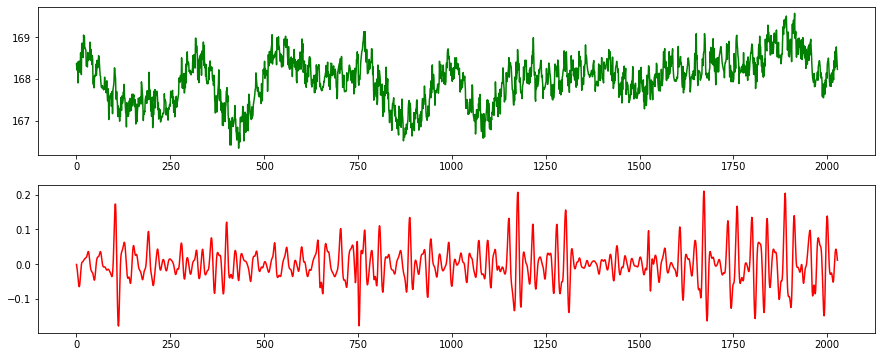

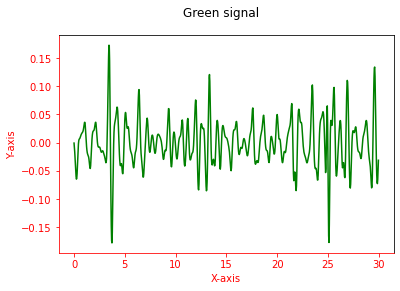

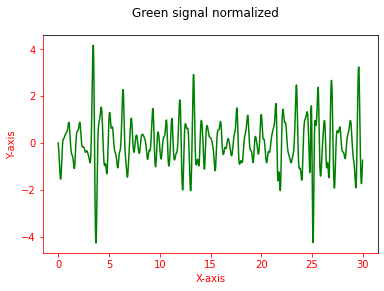

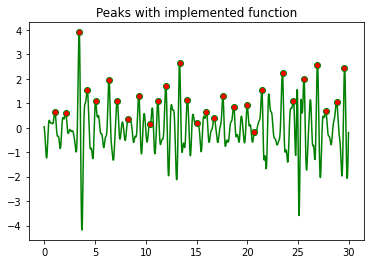

[2021-08-06 16:51:32,605] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 1.06666667  2.13333333  3.43333333  4.23333333  5.06666667  6.4
  7.2         8.3         9.3        10.4        11.2        11.96666667
 13.33333333 14.1        15.06666667 15.96666667 16.73333333 17.6
 18.66666667 20.         20.7        21.43333333 23.46666667 24.53333333
 25.56666667 26.9        27.73333333 28.8        29.56666667] num of peaks: 29


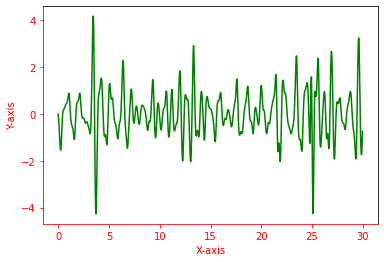

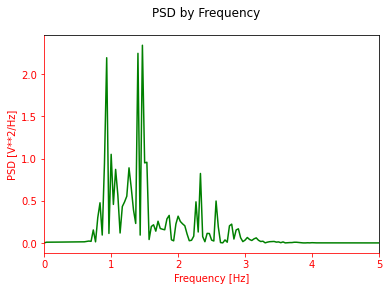

[2021-08-06 16:51:32,750] [INFO] [find_hr_in_window] [34] : Window 0:
Highest freq:1.4666666666666666
Heart rate: 88.0


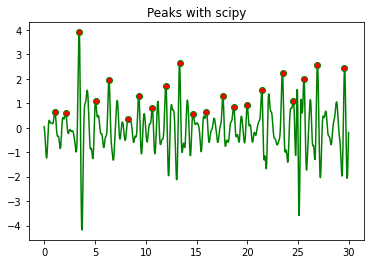

[2021-08-06 16:51:32,823] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 32  64 103 152 192 249 279 319 359 400 440 479 528 560 600 643 704 736
 767 807 887] num of peaks: 21


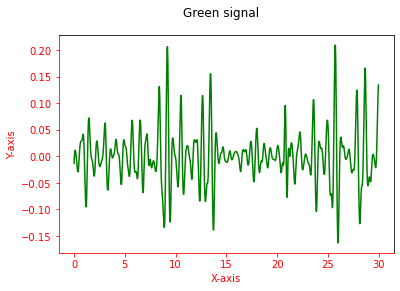

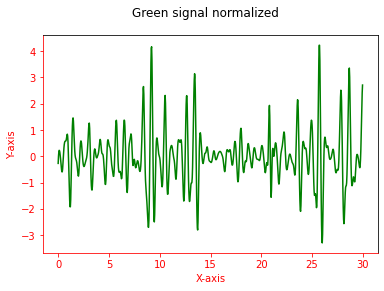

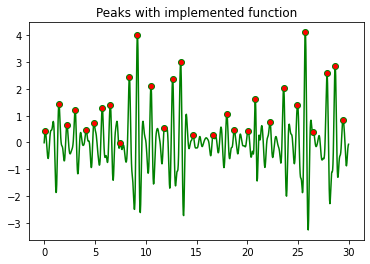

[2021-08-06 16:51:33,049] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.1         1.46666667  2.23333333  3.06666667  4.13333333  4.9
  5.73333333  6.5         7.5         8.4         9.16666667 10.53333333
 11.83333333 12.66666667 13.43333333 14.66666667 16.63333333 18.
 18.73333333 20.06666667 20.8        22.23333333 23.56666667 24.93333333
 25.7        26.5        27.83333333 28.66666667 29.43333333] num of peaks: 29


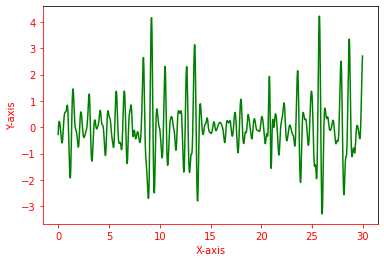

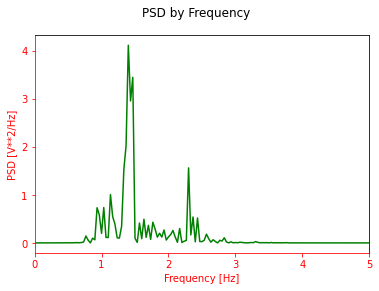

[2021-08-06 16:51:33,185] [INFO] [find_hr_in_window] [34] : Window 1:
Highest freq:1.4
Heart rate: 84.0


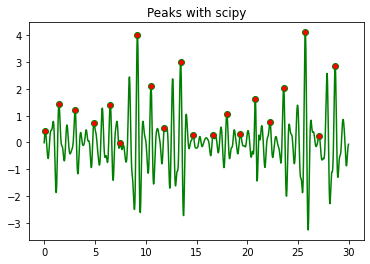

[2021-08-06 16:51:33,258] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [  3  44  92 147 195 225 275 316 355 403 440 499 540 579 624 667 707 771
 812 860] num of peaks: 20


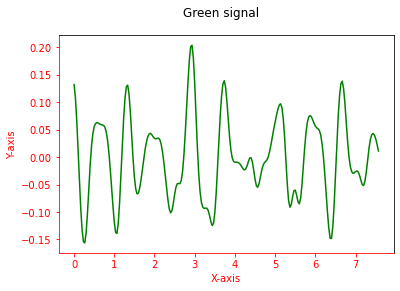

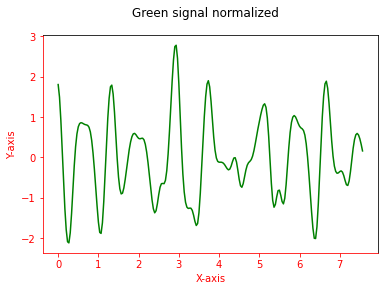

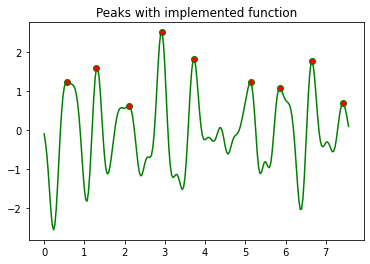

[2021-08-06 16:51:33,519] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [0.56666667 1.3        2.1        2.93333333 3.73333333 5.13333333
 5.86666667 6.66666667 7.43333333] num of peaks: 9


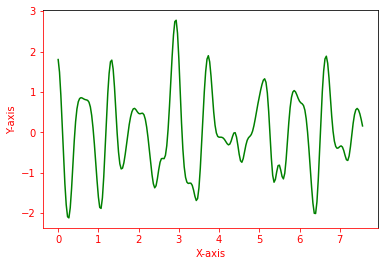

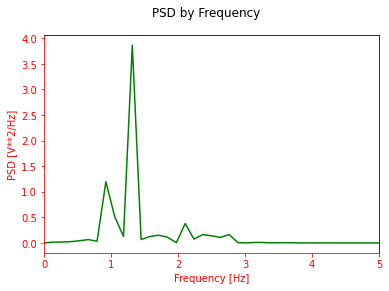

[2021-08-06 16:51:33,763] [INFO] [find_hr_in_window] [34] : Window 2:
Highest freq:1.3157894736842104
Heart rate: 78.94736842105263


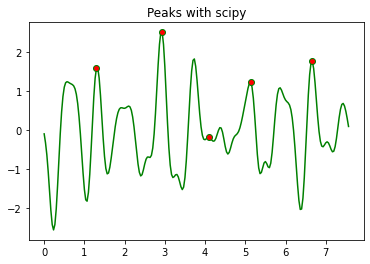

[2021-08-06 16:51:33,856] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 39  88 123 154 200] num of peaks: 5
[2021-08-06 16:51:33,856] [INFO] [<module>] [7] : Working on video C:\Users\eyalg\Downloads\dataset\subject9\Copy of vid.avi
[2021-08-06 16:51:33,860] [INFO] [<module>] [13] : Parsing images ...
[2021-08-06 16:51:33,860] [INFO] [<module>] [24] : Parsing frame 0/2016.0
[2021-08-06 16:52:21,098] [INFO] [<module>] [24] : Parsing frame 100/2016.0
[2021-08-06 16:53:09,906] [INFO] [<module>] [24] : Parsing frame 200/2016.0
[2021-08-06 16:53:56,201] [INFO] [<module>] [24] : Parsing frame 300/2016.0
[2021-08-06 16:54:41,816] [INFO] [<module>] [24] : Parsing frame 400/2016.0
[2021-08-06 16:55:26,747] [INFO] [<module>] [24] : Parsing frame 500/2016.0
[2021-08-06 16:56:14,670] [INFO] [<module>] [24] : Parsing frame 600/2016.0
[2021-08-06 16:57:08,343] [INFO] [<module>] [24] : Parsing frame 700/2016.0
[2021-08-06 16:58:04,442] [INFO] [<module>] [24] : Parsing frame 800/20

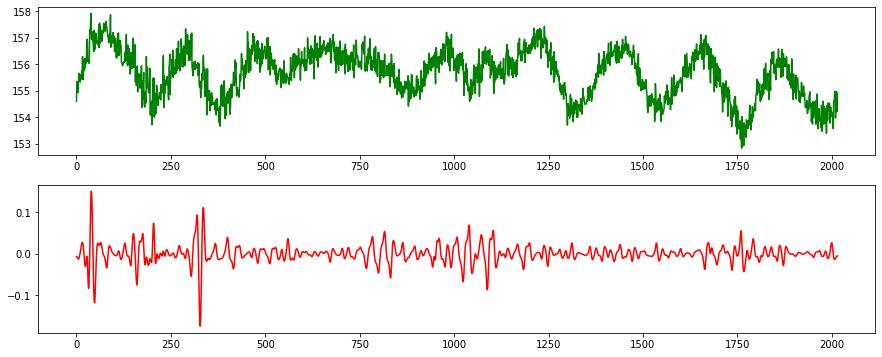

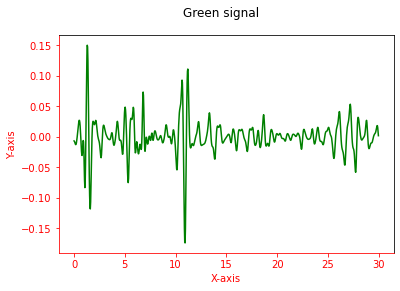

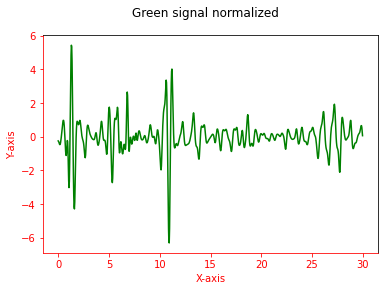

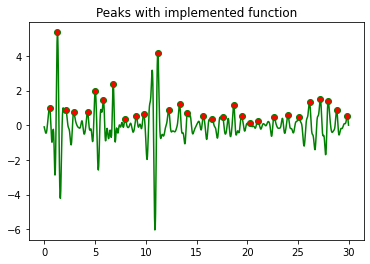

[2021-08-06 17:08:44,337] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.53333333  1.3         2.13333333  2.9         4.26666667  5.03333333
  5.83333333  6.8         7.96666667  9.06666667  9.8        11.2
 12.26666667 13.33333333 14.1        15.66666667 16.53333333 17.56666667
 18.66666667 19.43333333 20.26666667 21.03333333 22.63333333 24.
 25.06666667 26.13333333 27.2        27.96666667 28.8        29.83333333] num of peaks: 30


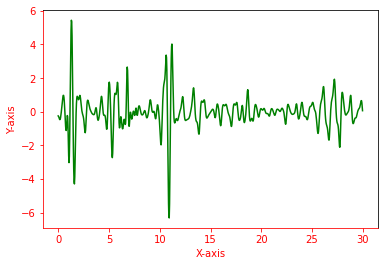

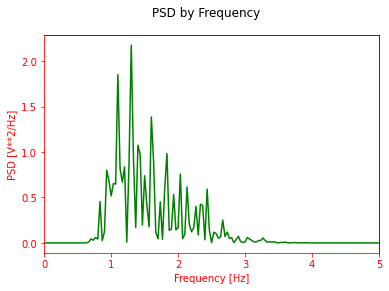

[2021-08-06 17:08:44,485] [INFO] [find_hr_in_window] [34] : Window 0:
Highest freq:1.3
Heart rate: 78.0


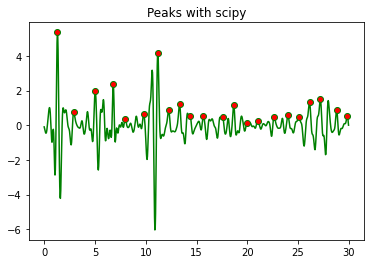

[2021-08-06 17:08:44,565] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 39  87 151 204 239 294 336 368 400 431 470 527 560 599 631 679 720 752
 784 816 864 895] num of peaks: 22


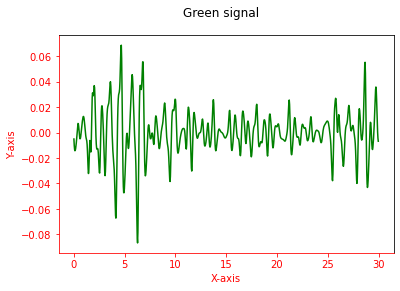

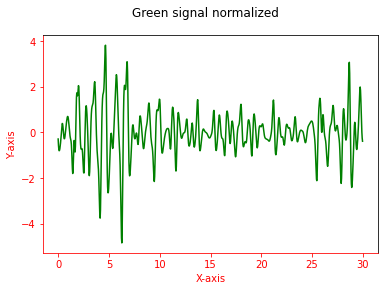

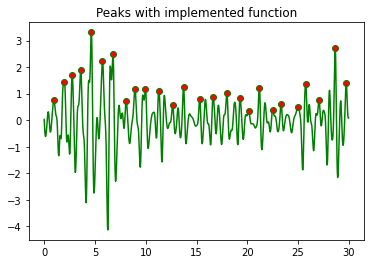

[2021-08-06 17:08:44,807] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.96666667  2.          2.76666667  3.6         4.63333333  5.73333333
  6.76666667  8.06666667  8.93333333  9.96666667 11.3        12.66666667
 13.73333333 15.33333333 16.63333333 18.         19.3        20.13333333
 21.2        22.5        23.33333333 25.         25.73333333 27.06666667
 28.66666667 29.73333333] num of peaks: 26


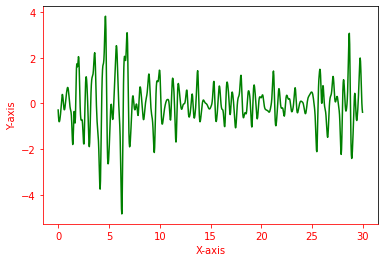

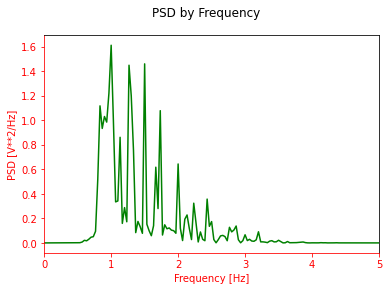

[2021-08-06 17:08:45,006] [INFO] [find_hr_in_window] [34] : Window 1:
Highest freq:1.0
Heart rate: 60.0


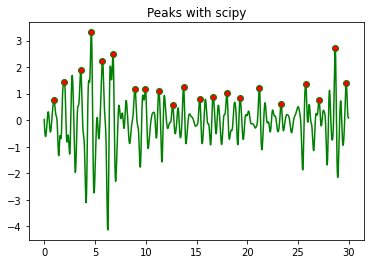

[2021-08-06 17:08:45,071] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 29  60 108 139 172 203 268 299 339 380 412 460 499 540 579 636 700 772
 812 860 892] num of peaks: 21


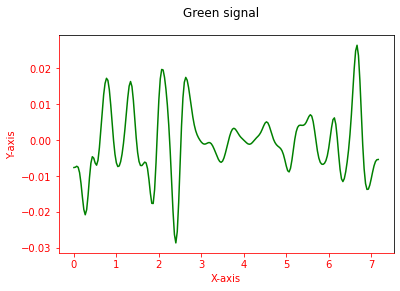

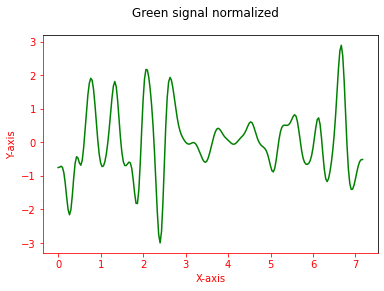

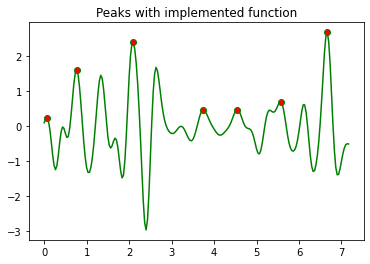

[2021-08-06 17:08:45,267] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [0.06666667 0.76666667 2.1        3.73333333 4.53333333 5.56666667
 6.66666667] num of peaks: 7


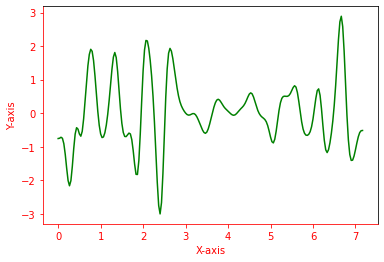

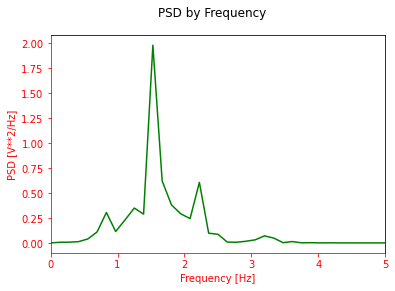

[2021-08-06 17:08:45,398] [INFO] [find_hr_in_window] [34] : Window 2:
Highest freq:1.527777777777778
Heart rate: 91.66666666666667


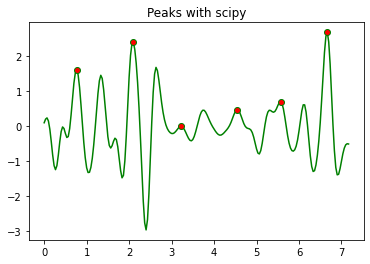

[2021-08-06 17:08:45,468] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 23  63  97 136 167 200] num of peaks: 6


In [15]:
# Parsing video:
for video_location in video_sources:
    color_sig = [[],[]]
    heart_rates = []
    good_frame_number = 0
    total_frame_number = 0
    logging.info("Working on video " + video_location)
    vidcap = cv2.VideoCapture(video_location)
    success, image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
    round_fps = np.round(fps)
    number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    logging.info("Parsing images ...")
    skipped_frames = 0
    bad_frames = 0
    max_luminance = 0
    min_luminance = 200
    avg_luminance = 0
    perv_luminance = None
    max_diff_luminance_adjacent = 0

    while success:
        if total_frame_number % 100 == 0:
            logging.info("Parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
        # build image ROI (rois is a tuple contains two regions)
        rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if rois is not None :
            try:
                # add mean value of the  green channel in the current frame to the signal
                is_good_frame,color_sig, luminance_level = parse_rgb(rois, color_sig)
                if perv_luminance is not None and luminance_level - perv_luminance > max_diff_luminance_adjacent:
                    max_diff_luminance_adjacent = luminance_level - perv_luminance
                if luminance_level > max_luminance:
                    max_luminance = luminance_level
                if luminance_level < min_luminance:
                    min_luminance = luminance_level
                avg_luminance += luminance_level
                perv_luminance = luminance_level
            except Exception as e:
                logging.error("failed to get output from parse_RGB!\nError:" + str(e))
                is_good_frame = False
                bad_frames += 1
            if is_good_frame:
                good_frame_number += 1
        if rois is None:
            bad_frames += 1
        total_frame_number += 1
        success, image = get_new_frame(vidcap)
    avg_luminance /= total_frame_number
    log_video_details(video_location)
    try:
        detect_hr(video_location) # detect the heart rate
    except Exception as e:
        logging.warning("Issue in detecting hr in video: " + str(e))